<a href="https://colab.research.google.com/github/wuziqin/wuziqin/blob/master/LSTM(07_06_21).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import the packages
import math
import statistics 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import scipy
!pip install tensorflow


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.5)
%matplotlib inline

In [3]:
# loads the raw data 
data = pd.read_excel("/data.xlsx")
data['Date']=pd.to_datetime(data.Date, format='%Y%m', errors='ignore')
data.tail()

,Date,Return,Index,D12,E12,tbl,AAA,BAA,lty,Rfree,ppiaco,indpro
1111,2018-08-01,0.032938,2901.52,52.338996,130.39,0.0203,0.0388,0.0477,0.028891,0.001692,-0.44053,0.80311
1112,2018-09-01,0.005138,2913.98,52.338996,130.39,0.0213,0.0398,0.0488,0.030042,0.001775,0.09833,0.13723
1113,2018-10-01,-0.068409,2711.74,53.748178,132.39,0.0225,0.0414,0.0507,0.031523,0.001875,0.49116,0.22029
1114,2018-11-01,0.019980,2760.17,53.748178,132.39,0.0233,0.0422,0.0522,0.031170,0.001942,-1.12414,0.53695
1115,2018-12-01,-0.090928,2506.85,53.748178,132.39,0.0237,0.0402,0.0513,0.028326,0.001975,-0.64261,0.04063


In [4]:
#construct the predictors
rfLag   = data["Rfree"]
ppigLag = data["ppiaco"]
ipgLag  = data["indpro"]

#Python's Indexes start from ZERO
startObs = 11
stock = []
date = []

for i in range(startObs,len(data)):
    a = data.Return[i]
    b = rfLag[i-1]
    stockC = a - b
    
    stock.append(stockC)
    
    dateC = data.Date[i]
    date.append(dateC)

stock = pd.DataFrame(stock)
date = pd.DataFrame(date)
stock = stock.multiply(100.0)


#rx
rx=pd.concat([date, stock], axis=1)
new_col = ['Date', 'stock']
rx.columns = new_col
rx=rx.reset_index(drop=True)
date['Date']=pd.to_datetime(data.Date, format='%Y%m', errors='ignore')


#vol, bill, bond, ma0112, ma0312, mom06, debug
vol = []
bill = []
bond=[]
ma0112 = []
ma0312 = []
mom06=[]
debug = []

for t in range(startObs,len(data)):
    volC=math.sqrt((math.pi)/2)*(math.sqrt(12))*(np.mean(abs(data.Return[(t-(startObs)-0):t+1])))
    vol.append(volC)
    
    billC = data.tbl[t-0]-np.mean(data.tbl[(t-(startObs)-0):t+1])
    bill.append(billC)
    
    bondC = data.lty[t-0]-np.mean(data.lty[(t-(startObs)-0):t+1])
    bond.append(bondC)
    
    ma0112C = int(data.Index[t]>np.mean(data.Index[(t-(startObs)-0):t+1]))
    ma0112.append(ma0112C)
    
    ma0312C = int(np.mean(data.Index[(t-2):t+1])>np.mean(data.Index[(t-(startObs)-0):t+1]))

   
    ma0312.append(ma0312C)
    
    mom06C = int(data.Index[t]>data.Index[t-6])
    mom06.append(mom06C)
    
vol = pd.DataFrame(vol)
bill = pd.DataFrame(bill)
bond = pd.DataFrame(bond)
ma0112 = pd.DataFrame(ma0112)
ma0312 = pd.DataFrame(ma0312)
mom06 = pd.DataFrame(mom06)
debug = pd.DataFrame(debug)


#de, ep, term, credit, ppig, ipg
date = []
dp = []
ep = []
term = []
credit = []
ppig = []
ipg = []


for t in range(startObs,len(data)):
    dateC = data.Date[t]
    date.append(dateC)
    
    dpC = math.log(data.D12[t]/data.Index[t])
    dp.append(dpC)

    epC = math.log(data.E12[t]/data.Index[t])
    ep.append(epC)
    
    
    termC = 100.0*(data.lty[t]-data.tbl[t])
    term.append(termC)

    creditC = 100.0*(data.AAA[t]-data.lty[t])
    credit.append(creditC)    
    
    
for m in range(10,len(data)-1):
    ipgC = ipgLag[m]
    ipg.append(ipgC)

    ppigC = ppigLag[m]
    ppig.append(ppigC)


date = pd.DataFrame(date)
dp = pd.DataFrame(dp)
ep = pd.DataFrame(ep)
term = pd.DataFrame(term)
credit = pd.DataFrame(credit)
ppig = pd.DataFrame(ppig)
ipg = pd.DataFrame(ipg)
vol = vol.multiply(100.0)
bill = bill.multiply(100.0)
bond = bond.multiply(100.0)

predictor = pd.concat([date, dp, ep, vol, bill, bond, term, credit, ppig, ipg, ma0112, ma0312, mom06],axis=1,ignore_index=True)
predictor.columns = ['Date', 'dp', 'ep', 'vol', 'bill', 'bond', 'term', 'credit', 'ppig', 'ipg', 'ma0112', 'ma0312', 'mom06']
predictor

,Date,dp,ep,vol,bill,bond,term,credit,ppig,ipg,ma0112,ma0312,mom06
0,1926-12-01,-2.973012,-2.386837,13.320052,-0.162500,-0.140000,0.470000,1.140000,-0.58480,-0.39851,1,1,1
1,1927-01-01,-2.942374,-2.374773,13.360827,0.019167,-0.150833,0.280000,1.150000,-0.58824,-0.40010,1,1,1
2,1927-02-01,-2.979535,-2.430353,13.803164,0.070000,-0.170000,0.180000,1.200000,-2.95858,-0.40171,1,1,1
3,1927-03-01,-2.976535,-2.445079,11.980268,-0.025000,-0.296667,0.110000,1.310000,1.21951,0.80666,1,1,1
4,1927-04-01,-2.984225,-2.471309,11.057640,0.139167,-0.247500,-0.060000,1.250000,-0.60241,1.20031,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,2018-08-01,-4.015248,-3.102460,11.303303,0.460000,0.125591,0.859130,0.990870,0.04897,0.44494,1,1,1
1101,2018-09-01,-4.019533,-3.106745,10.763786,0.468333,0.206154,0.874211,0.975789,-0.44053,0.80311,1,1,1
1102,2018-10-01,-3.921036,-3.019594,12.364790,0.490000,0.309026,0.902273,0.987727,0.09833,0.13723,0,1,1
1103,2018-11-01,-3.938738,-3.037295,11.952011,0.478333,0.230670,0.787000,1.103000,0.49116,0.22029,1,1,1


In [5]:
predictor.drop(axis=0, index=0, inplace=True)
predictor

,Date,dp,ep,vol,bill,bond,term,credit,ppig,ipg,ma0112,ma0312,mom06
1,1927-01-01,-2.942374,-2.374773,13.360827,0.019167,-0.150833,0.280000,1.150000,-0.58824,-0.40010,1,1,1
2,1927-02-01,-2.979535,-2.430353,13.803164,0.070000,-0.170000,0.180000,1.200000,-2.95858,-0.40171,1,1,1
3,1927-03-01,-2.976535,-2.445079,11.980268,-0.025000,-0.296667,0.110000,1.310000,1.21951,0.80666,1,1,1
4,1927-04-01,-2.984225,-2.471309,11.057640,0.139167,-0.247500,-0.060000,1.250000,-0.60241,1.20031,1,1,1
5,1927-05-01,-3.025963,-2.531446,12.820695,0.065833,-0.272500,-0.060000,1.300000,-1.21212,-2.37215,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,2018-08-01,-4.015248,-3.102460,11.303303,0.460000,0.125591,0.859130,0.990870,0.04897,0.44494,1,1,1
1101,2018-09-01,-4.019533,-3.106745,10.763786,0.468333,0.206154,0.874211,0.975789,-0.44053,0.80311,1,1,1
1102,2018-10-01,-3.921036,-3.019594,12.364790,0.490000,0.309026,0.902273,0.987727,0.09833,0.13723,0,1,1
1103,2018-11-01,-3.938738,-3.037295,11.952011,0.478333,0.230670,0.787000,1.103000,0.49116,0.22029,1,1,1


In [6]:
predictor = predictor[:-1]
predictor

,Date,dp,ep,vol,bill,bond,term,credit,ppig,ipg,ma0112,ma0312,mom06
1,1927-01-01,-2.942374,-2.374773,13.360827,0.019167,-0.150833,0.280000,1.150000,-0.58824,-0.40010,1,1,1
2,1927-02-01,-2.979535,-2.430353,13.803164,0.070000,-0.170000,0.180000,1.200000,-2.95858,-0.40171,1,1,1
3,1927-03-01,-2.976535,-2.445079,11.980268,-0.025000,-0.296667,0.110000,1.310000,1.21951,0.80666,1,1,1
4,1927-04-01,-2.984225,-2.471309,11.057640,0.139167,-0.247500,-0.060000,1.250000,-0.60241,1.20031,1,1,1
5,1927-05-01,-3.025963,-2.531446,12.820695,0.065833,-0.272500,-0.060000,1.300000,-1.21212,-2.37215,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,2018-07-01,-3.985434,-3.072646,10.192575,0.475000,0.164603,0.929048,0.980952,0.49213,0.75146,1,1,0
1100,2018-08-01,-4.015248,-3.102460,11.303303,0.460000,0.125591,0.859130,0.990870,0.04897,0.44494,1,1,1
1101,2018-09-01,-4.019533,-3.106745,10.763786,0.468333,0.206154,0.874211,0.975789,-0.44053,0.80311,1,1,1
1102,2018-10-01,-3.921036,-3.019594,12.364790,0.490000,0.309026,0.902273,0.987727,0.09833,0.13723,0,1,1


In [7]:
#date & rx
startSample =pd.Timestamp('1927-01-01')
rx=rx[rx['Date']>=startSample]
predictor=predictor[predictor['Date']>=startSample]
date.columns = ['Date']
date = date[date['Date']>=startSample]

In [8]:
date

,Date
1,1927-01-01
2,1927-02-01
3,1927-03-01
4,1927-04-01
5,1927-05-01
...,...
1100,2018-08-01
1101,2018-09-01
1102,2018-10-01
1103,2018-11-01


In [9]:
rx

,Date,stock
1,1927-01-01,-0.546833
2,1927-02-01,4.283033
3,1927-03-01,0.458233
4,1927-04-01,1.035433
5,1927-05-01,5.952800
...,...,...
1100,2018-08-01,3.130467
1101,2018-09-01,0.344633
1102,2018-10-01,-7.018400
1103,2018-11-01,1.810500


In [10]:
# This section takes care of preliminaries for out-of-sample forecasting: 1947.01 - 1956.12
endIn = pd.Timestamp('1927-01-01')
endInIndex = date.Date[date.Date == endIn].index.values
endInIndex = endInIndex[0]
lengthOut = len(date)-endInIndex
lengthIn = len(date)-lengthOut

endHold = pd.Timestamp('2018-12-01')
endHoldIndex  =date.Date[date.Date == endHold].index.values
endHoldIndex = endHoldIndex[0]
lengthHold = endHoldIndex - endInIndex

In [11]:
actual = rx.stock[endInIndex:]
actual.reset_index(drop=True, inplace=True) 

date = date.Date[endInIndex:]
date.reset_index(drop=True, inplace=True) 

date.tail()

1098   2018-08-01
1099   2018-09-01
1100   2018-10-01
1101   2018-11-01
1102   2018-12-01
Name: Date, dtype: datetime64[ns]

In [12]:
actual = pd.DataFrame(actual)
tableActual = pd.concat([date,actual],axis = 1)
tableActual.columns = ['Date', 'return']
tableActual.to_csv("tableActual.csv",index = False)
tableActual

,Date,return
0,1927-02-01,4.283033
1,1927-03-01,0.458233
2,1927-04-01,1.035433
3,1927-05-01,5.952800
4,1927-06-01,-2.314500
...,...,...
1098,2018-08-01,3.130467
1099,2018-09-01,0.344633
1100,2018-10-01,-7.018400
1101,2018-11-01,1.810500


In [13]:
df_final = pd.merge(left=predictor, right=tableActual, how='inner',
               left_on='Date', right_on='Date')

In [14]:
df_final.rename(columns={'return':'return_1_month_after'}, inplace = True)
df_final


,Date,dp,ep,vol,bill,bond,term,credit,ppig,ipg,ma0112,ma0312,mom06,return_1_month_after
0,1927-02-01,-2.979535,-2.430353,13.803164,0.070000,-0.170000,0.180000,1.200000,-2.95858,-0.40171,1,1,1,4.283033
1,1927-03-01,-2.976535,-2.445079,11.980268,-0.025000,-0.296667,0.110000,1.310000,1.21951,0.80666,1,1,1,0.458233
2,1927-04-01,-2.984225,-2.471309,11.057640,0.139167,-0.247500,-0.060000,1.250000,-0.60241,1.20031,1,1,1,1.035433
3,1927-05-01,-3.025963,-2.531446,12.820695,0.065833,-0.272500,-0.060000,1.300000,-1.21212,-2.37215,1,1,1,5.952800
4,1927-06-01,-3.007309,-2.531330,11.516150,-0.205833,-0.174167,0.270000,1.240000,-0.61350,0.80993,1,1,1,-2.314500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,2018-07-01,-3.985434,-3.072646,10.192575,0.475000,0.164603,0.929048,0.980952,0.49213,0.75146,1,1,0,3.556067
1098,2018-08-01,-4.015248,-3.102460,11.303303,0.460000,0.125591,0.859130,0.990870,0.04897,0.44494,1,1,1,3.130467
1099,2018-09-01,-4.019533,-3.106745,10.763786,0.468333,0.206154,0.874211,0.975789,-0.44053,0.80311,1,1,1,0.344633
1100,2018-10-01,-3.921036,-3.019594,12.364790,0.490000,0.309026,0.902273,0.987727,0.09833,0.13723,0,1,1,-7.018400


Text(0.5, 1.0, 'excess return')

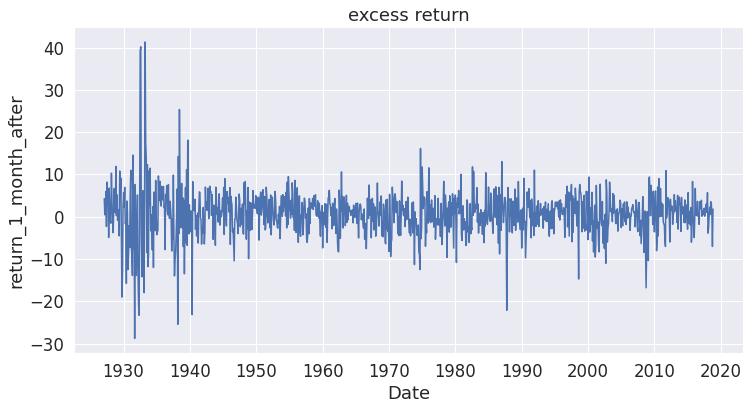

In [15]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df_final.Date, y=df_final['return_1_month_after'], data=df_final).set_title("excess return")

In [16]:

#for i in range(len(df_final)):
#    data.iloc[:,[0]] #取第0列所有行，多取几列格式为 
x=df_final.iloc[:,1:13]
y=df_final.iloc[:,13]
y = pd.DataFrame(y)

#train_x=x.iloc[,:]

#    a = df_final.iloc[i:]
#    b = df_final.iloc[i:]
#    x.append(a)
#    y.append(b)

In [17]:
train_x=x.iloc[0:900,:]
test_x=x.iloc[900:,:]

In [18]:
train_y=y.iloc[0:900,:]
test_y=y.iloc[900:,:]

In [19]:
trainx = np.array(train_x)
trainy= np.array(train_y)

In [20]:
testx = np.array(test_x)
testy= np.array(test_y)

In [21]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(trainx)
X_test = sc.fit_transform(testx)
y_train = sc.fit_transform(trainy)
y_test = sc.fit_transform(testy)

In [22]:
X_train = X_train.reshape((len(X_train), 12, 1))
X_test  = X_test.reshape((len(X_test), 12, 1))

In [26]:
import tensorflow as tf
from tensorflow.keras import layers

In [41]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(90,1)))
model.add(layers.LSTM(units=32, return_sequences=True,
                  ))
model.add(layers.LSTM(units=32,))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 90, 32)            4352      
_________________________________________________________________
lstm_4 (LSTM)                (None, 90, 32)            8320      
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [43]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
29/29 [==============================] - 4s 11ms/step - loss: 0.0475
Epoch 2/5
29/29 [==============================] - 0s 11ms/step - loss: 0.0073
Epoch 3/5
29/29 [==============================] - 0s 12ms/step - loss: 0.0066
Epoch 4/5
29/29 [==============================] - 0s 12ms/step - loss: 0.0067
Epoch 5/5
29/29 [==============================] - 0s 12ms/step - loss: 0.0065


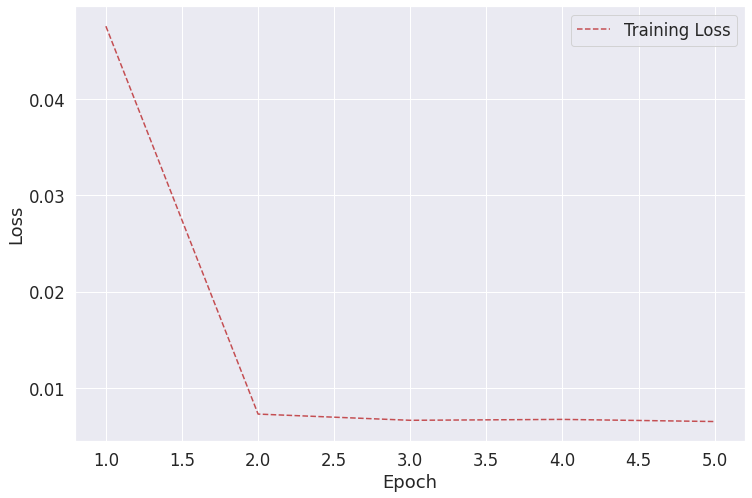

In [44]:
loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

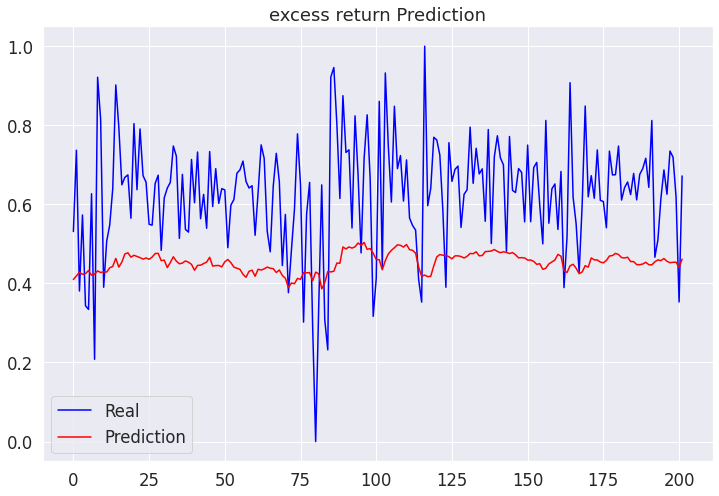

In [45]:
pred = model.predict(X_test)
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('excess return Prediction')
plt.legend()
plt.show()

In [32]:
pred_transformed = sc.inverse_transform(pred)
y_test_transformed = sc.inverse_transform(y_test)